## Building a model to check the work of volunteers
To find out, answer the following questions:
* Do title length, article length, or average length of words play a role in an article's popularity?
    * Hypothesis: Shorter articles with shorter titles and shorter words (simpler vocabulary) will garner more shares on average.
* Do certain genres lead to more popular articles? 
    * Hypothesis: Certain genres will receive more shares on average.
* What effect does the day of publication have?
    * Hypothesis: The day of publication will not have an impact on an article's shares.
* Do articles that skew positive, negative, or neutral perform better?
    * Hypothesis: More negative, outrageous (higher subjectivity) articles will be shared more on average.
* What effect do SEO terms have?
    * Hypothesis: Better performing SEO terms (keywords) will have a positive impact on an article's shares.
    
## Approach
Using UCI's [Online News Popularity Data Set](http://archive.ics.uci.edu/ml/datasets/Online+News+Popularity), I perform statistical tests to measure the significance of certain variables on the number of social media shares an article receives. During my exploratory data analysis, I create graphs that answer some of my objective questions. I then create a linear regression model, from which I can infer the strongest predictors based on the coefficients within the model.

## Cleaning and exploring the data
* Import the necessary libraries.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('ticks')

import pickle

from functions import *
%load_ext autoreload
%autoreload 2

from scipy import stats
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

import warnings
warnings.filterwarnings('ignore')

# POSSIBLY
from collections import Counter

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  depr

* Import the data and take a look.

In [2]:
trees = pd.read_csv('data/2015StreetTreesCensus_TREES.csv')
trees.head()

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,st_assem,st_senate,nta,nta_name,boro_ct,state,Latitude,longitude,x_sp,y_sp
0,08/27/2015,180683,348711,POINT (-73.84421521958048 40.723091773924274),3,0,OnCurb,Alive,Fair,Acer rubrum,...,28,16,QN17,Forest Hills,4073900,New York,40.723092,-73.844215,1.027431e+06,202756.768749
1,09/03/2015,200540,315986,POINT (-73.81867945834878 40.79411066708779),21,0,OnCurb,Alive,Fair,Quercus palustris,...,27,11,QN49,Whitestone,4097300,New York,40.794111,-73.818679,1.034456e+06,228644.837379
2,09/05/2015,204026,218365,POINT (-73.93660770459083 40.717580740099116),3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,50,18,BK90,East Williamsburg,3044900,New York,40.717581,-73.936608,1.001823e+06,200716.891267
3,09/05/2015,204337,217969,POINT (-73.93445615919741 40.713537494833226),10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,53,18,BK90,East Williamsburg,3044900,New York,40.713537,-73.934456,1.002420e+06,199244.253136
4,08/30/2015,189565,223043,POINT (-73.97597938483258 40.66677775537875),21,0,OnCurb,Alive,Good,Tilia americana,...,44,21,BK37,Park Slope-Gowanus,3016500,New York,40.666778,-73.975979,9.909138e+05,182202.425999


In [3]:
trees.shape

(683788, 42)

In [4]:
trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 42 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   created_at  683788 non-null  object 
 1   tree_id     683788 non-null  int64  
 2   block_id    683788 non-null  int64  
 3   the_geom    683788 non-null  object 
 4   tree_dbh    683788 non-null  int64  
 5   stump_diam  683788 non-null  int64  
 6   curb_loc    683788 non-null  object 
 7   status      683788 non-null  object 
 8   health      652172 non-null  object 
 9   spc_latin   652169 non-null  object 
 10  spc_common  652169 non-null  object 
 11  steward     652173 non-null  object 
 12  guards      652172 non-null  object 
 13  sidewalk    652172 non-null  object 
 14  user_type   683788 non-null  object 
 15  problems    652124 non-null  object 
 16  root_stone  683788 non-null  object 
 17  root_grate  683788 non-null  object 
 18  root_other  683788 non-null  object 
 19  tr

In [5]:
trees.describe()

,tree_id,block_id,tree_dbh,stump_diam,zipcode,cb_num,borocode,cncldist,st_assem,st_senate,boro_ct,Latitude,longitude,x_sp,y_sp
count,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,6.837880e+05,683788.000000,683788.000000,6.837880e+05,683788.000000
mean,365205.011085,313793.096236,11.279787,0.432463,10916.246044,343.505404,3.358500,29.943181,50.791583,20.615781,3.404914e+06,40.701261,-73.924060,1.005280e+06,194798.424624
std,208122.092902,114839.024312,8.723042,3.290241,651.553364,115.740601,1.166746,14.328531,18.966520,7.390844,1.175863e+06,0.090311,0.123583,3.428505e+04,32902.061114
min,3.000000,100002.000000,0.000000,0.000000,83.000000,101.000000,1.000000,1.000000,23.000000,10.000000,1.000201e+06,40.498466,-74.254965,9.133493e+05,120973.792223
25%,186582.750000,221556.000000,4.000000,0.000000,10451.000000,302.000000,3.000000,19.000000,33.000000,14.000000,3.011700e+06,40.631928,-73.980500,9.896578e+05,169515.153719
50%,366214.500000,319967.000000,9.000000,0.000000,11214.000000,402.000000,4.000000,30.000000,52.000000,21.000000,4.008100e+06,40.700612,-73.912911,1.008386e+06,194560.252497
75%,546170.250000,404624.000000,16.000000,0.000000,11365.000000,412.000000,4.000000,43.000000,64.000000,25.000000,4.103202e+06,40.762228,-73.834910,1.029991e+06,217019.571916
max,722694.000000,999999.000000,450.000000,140.000000,11697.000000,503.000000,5.000000,51.000000,87.000000,36.000000,5.032300e+06,40.912918,-73.700488,1.067248e+06,271894.092088


* Rename some columns.

In [6]:
trees.columns = ['created_at', 'tree_id', 'block_id', 'the_geom', 'tree_dbh',
       'stump_diam', 'curb_loc', 'status', 'health', 'spc_latin', 'spc_common',
       'steward', 'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
       'branch_light', 'branch_shoe', 'branch_other', 'address', 'zipcode',
       'zip_city', 'cb_num', 'borocode', 'boroname', 'council_dist', 'st_assem',
       'st_senate', 'nta', 'nta_name', 'boro_ct', 'state', 'latitude',
       'longitude', 'x_sp', 'y_sp']

* Remove stumps and dead trees.

In [7]:
trees.status.value_counts()

Alive    652173
Stump     17654
Dead      13961
Name: status, dtype: int64

In [8]:
# Get indices of dead trees and stumps
dead = trees[trees.status.isin(['Dead', 'Stump'])].index
 
# Delete these row indices from dataFrame
trees.drop(dead, inplace=True)

trees.shape

(652173, 42)

* We want to build a model based on the professional entries, so let's drop all of the volunteer entries.

In [9]:
trees.user_type.value_counts()

TreesCount Staff    282259
Volunteer           207777
NYC Parks Staff     162137
Name: user_type, dtype: int64

In [10]:
# Get indices of volunteer
volunteers = trees[trees.user_type == 'Volunteer'].index
 
# Delete these row indices from dataFrame
trees.drop(volunteers, inplace=True)

trees.shape

(444396, 42)

* Look for NaN values.

In [11]:
trees.isna().sum()

created_at       0
tree_id          0
block_id         0
the_geom         0
tree_dbh         0
stump_diam       0
curb_loc         0
status           0
health           1
spc_latin        4
spc_common       4
steward          0
guards           1
sidewalk         1
user_type        0
problems        45
root_stone       0
root_grate       0
root_other       0
trunk_wire       0
trunk_light      0
trunk_other      0
branch_light     0
branch_shoe      0
branch_other     0
address          0
zipcode          0
zip_city         0
cb_num           0
borocode         0
boroname         0
council_dist     0
st_assem         0
st_senate        0
nta              0
nta_name         0
boro_ct          0
state            0
latitude         0
longitude        0
x_sp             0
y_sp             0
dtype: int64

* Replace NaNs in 'problems' column with 'None', in case we end up using that column.
* Drop the few rows with missing values for our target variable and species of tree.

In [12]:
trees.problems.fillna(value='None', inplace=True)

In [13]:
trees.dropna(how='any', axis=0, inplace=True)

* Create and pickle a dictionary of neighborhood codes and names, in case we want that later.

In [14]:
nta = list(trees['nta'].unique())

In [15]:
nta_name = list(trees['nta_name'].unique())

In [16]:
nta_dict = {k: v for k,v in zip(nta, nta_name)}

In [17]:
with open('data/nta_dict.pickle', 'wb') as f:
    pickle.dump(nta_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

* Drop unnecessary columns and set index to each tree's unique ID.

In [18]:
trees.columns

Index(['created_at', 'tree_id', 'block_id', 'the_geom', 'tree_dbh',
       'stump_diam', 'curb_loc', 'status', 'health', 'spc_latin', 'spc_common',
       'steward', 'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
       'branch_light', 'branch_shoe', 'branch_other', 'address', 'zipcode',
       'zip_city', 'cb_num', 'borocode', 'boroname', 'council_dist',
       'st_assem', 'st_senate', 'nta', 'nta_name', 'boro_ct', 'state',
       'latitude', 'longitude', 'x_sp', 'y_sp'],
      dtype='object')

In [19]:
drop_cols = ['created_at', 'block_id', 'the_geom', 'stump_diam', 'status', 'spc_latin', 'user_type', 'problems',
             'address', 'zipcode', 'zip_city', 'borocode', 'council_dist', 'st_assem', 'st_senate', 'nta_name',
             'boro_ct', 'state', 'latitude', 'longitude', 'x_sp', 'y_sp']
trees.drop(columns=drop_cols, inplace=True)
trees.set_index(['tree_id'], inplace=True)
trees.shape

(444390, 19)

In [20]:
trees.head()

,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,root_stone,root_grate,root_other,trunk_wire,trunk_light,trunk_other,branch_light,branch_shoe,branch_other,cb_num,boroname,nta
tree_id,,,,,,,,,,,,,,,,,,,
180683,3,OnCurb,Fair,red maple,None,None,NoDamage,No,No,No,No,No,No,No,No,No,406,Queens,QN17
200540,21,OnCurb,Fair,pin oak,None,None,Damage,Yes,No,No,No,No,No,No,No,No,407,Queens,QN49
209610,6,OnCurb,Good,honeylocust,None,None,NoDamage,No,No,No,No,No,No,No,No,No,502,Staten Island,SI14
192755,21,OffsetFromCurb,Fair,London planetree,None,None,NoDamage,No,No,No,No,No,No,No,No,No,313,Brooklyn,BK26
195202,13,OnCurb,Fair,London planetree,None,None,NoDamage,Yes,No,No,No,No,No,No,No,No,503,Staten Island,SI54


* Take a look at our target variable.

In [21]:
trees.health.value_counts()

Good    363591
Fair     63048
Poor     17751
Name: health, dtype: int64

In [22]:
trees.health.value_counts(normalize=True)

Good    0.818180
Fair    0.141875
Poor    0.039945
Name: health, dtype: float64

* Let's make a numeric column for our target variable, as this will help us with some of the statistical tests.

In [23]:
conditions = [
    trees.health == 'Good',
    trees.health == 'Fair'
]

choices = [
    2,
    1
]

trees['health_num'] = np.select(conditions, choices, 0)

### EDA - Boroughs

In [24]:
trees.boroname.value_counts()

Queens           164820
Staten Island     95733
Brooklyn          95101
Bronx             68082
Manhattan         20654
Name: boroname, dtype: int64

In [25]:
trees.groupby('boroname').health.value_counts()

boroname       health
Bronx          Good       57183
               Fair        8409
               Poor        2490
Brooklyn       Good       76921
               Fair       14375
               Poor        3805
Manhattan      Good       16084
               Fair        3420
               Poor        1150
Queens         Good      135189
               Fair       23364
               Poor        6267
Staten Island  Good       78214
               Fair       13480
               Poor        4039
Name: health, dtype: int64

In [26]:
trees.groupby('boroname').health.value_counts(normalize=True)

boroname       health
Bronx          Good      0.839914
               Fair      0.123513
               Poor      0.036574
Brooklyn       Good      0.808835
               Fair      0.151155
               Poor      0.040010
Manhattan      Good      0.778735
               Fair      0.165585
               Poor      0.055679
Queens         Good      0.820222
               Fair      0.141755
               Poor      0.038023
Staten Island  Good      0.817001
               Fair      0.140808
               Poor      0.042190
Name: health, dtype: float64

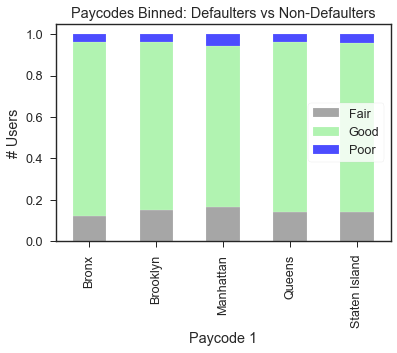

In [27]:
boros = trees.groupby(['boroname']).health.value_counts(normalize=True).unstack()
p1 = boros.plot(kind = 'bar', stacked = True, 
                   title = 'Paycodes Binned: Defaulters vs Non-Defaulters', 
                   color = ['grey','lightgreen', 'blue'], alpha = .70)
p1.set_xlabel('Paycode 1')
p1.set_ylabel('# Users')
p1.legend(['Fair','Good', 'Poor'])
plt.show()

In [28]:
stats.f_oneway(trees['health_num'][trees['boroname'] == 'Bronx'],
               trees['health_num'][trees['boroname'] == 'Brooklyn'],
               trees['health_num'][trees['boroname'] == 'Manhattan'],
               trees['health_num'][trees['boroname'] == 'Queens'],
               trees['health_num'][trees['boroname'] == 'Staten Island'])

F_onewayResult(statistic=116.89435222454642, pvalue=7.770639956563353e-100)

In [29]:
boros_list = [trees['health_num'][trees['boroname'] == 'Bronx'],
               trees['health_num'][trees['boroname'] == 'Brooklyn'],
               trees['health_num'][trees['boroname'] == 'Manhattan'],
               trees['health_num'][trees['boroname'] == 'Queens'],
               trees['health_num'][trees['boroname'] == 'Staten Island']]

In [30]:
two_way_tests(boros_list)

{(0,
  1): Ttest_indResult(statistic=13.84342341533481, pvalue=1.4755442137242058e-43),
 (0,
  2): Ttest_indResult(statistic=20.21817657922981, pvalue=1.0856247968724517e-90),
 (0,
  3): Ttest_indResult(statistic=9.434247565526626, pvalue=3.972481985469369e-21),
 (0,
  4): Ttest_indResult(statistic=11.442187393876186, pvalue=2.642364529228648e-30),
 (1,
  2): Ttest_indResult(statistic=11.530265119889332, pvalue=9.652292564952115e-31),
 (1,
  3): Ttest_indResult(statistic=-6.561169683298543, pvalue=5.3486949272348975e-11),
 (1,
  4): Ttest_indResult(statistic=-2.5727343861263505, pvalue=0.010090609564694262),
 (2,
  3): Ttest_indResult(statistic=-15.908508121045836, pvalue=6.034011829704148e-57),
 (2,
  4): Ttest_indResult(statistic=-13.025223204781993, pvalue=9.361485569017078e-39),
 (3,
  4): Ttest_indResult(statistic=3.6288098143024174, pvalue=0.00028478530691402514)}

In [31]:
# create a dictionary of borough names and their datapoints to perform two-way t-tests on
boro_dict = {boro: trees['health_num'][trees['boroname'] == boro] for boro in list(trees.boroname.unique())}
# run two-way t-tests function
two_way_tests_dicts(boro_dict)

{('Queens',
  'Staten Island'): Ttest_indResult(statistic=3.6288098143024174, pvalue=0.00028478530691402514),
 ('Queens',
  'Brooklyn'): Ttest_indResult(statistic=6.561169683298543, pvalue=5.3486949272348975e-11),
 ('Queens',
  'Manhattan'): Ttest_indResult(statistic=15.908508121045836, pvalue=6.034011829704148e-57),
 ('Queens',
  'Bronx'): Ttest_indResult(statistic=-9.434247565526626, pvalue=3.972481985469369e-21),
 ('Staten Island',
  'Brooklyn'): Ttest_indResult(statistic=2.5727343861263505, pvalue=0.010090609564694262),
 ('Staten Island',
  'Manhattan'): Ttest_indResult(statistic=13.025223204781993, pvalue=9.361485569017078e-39),
 ('Staten Island',
  'Bronx'): Ttest_indResult(statistic=-11.442187393876186, pvalue=2.642364529228648e-30),
 ('Brooklyn',
  'Manhattan'): Ttest_indResult(statistic=11.530265119889332, pvalue=9.652292564952115e-31),
 ('Brooklyn',
  'Bronx'): Ttest_indResult(statistic=-13.84342341533481, pvalue=1.4755442137242058e-43),
 ('Manhattan',
  'Bronx'): Ttest_indRe

In [32]:
df_bronx = trees[trees.boroname=='Bronx']
df_brooklyn = trees[trees.boroname=='Brooklyn']
df_manhattan = trees[trees.boroname=='Manhattan']
df_queens = trees[trees.boroname=='Queens']
df_si =trees[trees.boroname=='Staten Island']

df_freq = pd.DataFrame(columns=['bronx', 'brooklyn', 'manhattan', 'queens', 'si'])
df_freq['bronx'] = df_bronx.groupby('health')['health'].count()
df_freq['brooklyn'] = df_brooklyn.groupby('health')['health'].count()
df_freq['manhattan'] = df_manhattan.groupby('health')['health'].count()
df_freq['queens'] = df_queens.groupby('health')['health'].count()
df_freq['si'] = df_si.groupby('health')['health'].count()
df_freq.head()

,bronx,brooklyn,manhattan,queens,si
health,,,,,
Fair,8409,14375,3420,23364,13480
Good,57183,76921,16084,135189,78214
Poor,2490,3805,1150,6267,4039


In [33]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_freq)

In [34]:
stats.chi2_contingency(df_freq)

(566.5988905003828,
 3.530263683508544e-117,
 8,
 array([[  9659.15960305,  13492.49048808,   2930.29409303,
          23383.90008776,  13582.15572808],
        [ 55703.32919733,  77809.73399716,  16898.68924593,
         134852.42381692,  78326.82374266],
        [  2719.51119962,   3798.77551475,    825.01666104,
           6583.67609532,   3824.02052926]]))

In [35]:
# interpret test-statistic
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
critical, stat

(15.50731305586545, 566.5988905003828)

### EDA - Tree diameter

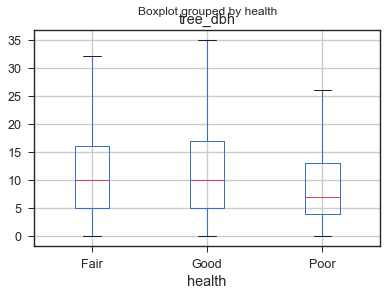

In [36]:
trees.boxplot('tree_dbh', 'health', showfliers=False)

### EDA - Community Boards

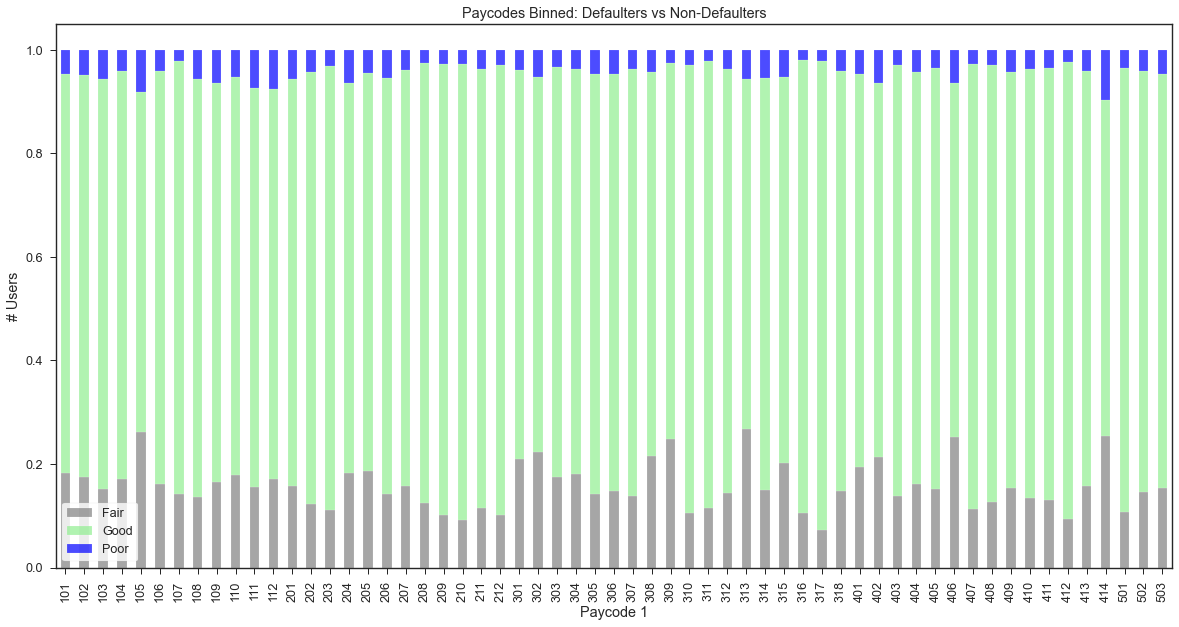

In [37]:
community_boards = trees.groupby(['cb_num']).health.value_counts(normalize=True).unstack()
p2 = community_boards.plot(kind = 'bar', stacked = True, figsize=(20,10),
                   title = 'Paycodes Binned: Defaulters vs Non-Defaulters', 
                   color = ['grey','lightgreen', 'blue'], alpha = .70)
p2.set_xlabel('Paycode 1')
p2.set_ylabel('# Users')
p2.legend(['Fair','Good', 'Poor'])
plt.show()

In [38]:
# create a dictionary of community boards and their datapoints to perform two-way t-tests on
cbs_dict = {cb: trees['health_num'][trees['cb_num'] == cb] for cb in list(trees.cb_num.unique())}
# run two-way t-tests function
cb_t_test_dict = two_way_tests_dicts(cbs_dict)
# compare amount of statistically significant to statistically insignificant
significant = len({k:v for k,v in cb_t_test_dict.items() if cb_t_test_dict[k].pvalue < 0.05})
insignificant = len({k:v for k,v in cb_t_test_dict.items() if cb_t_test_dict[k].pvalue > 0.05})
print(f'Amount of statistically significant comparisons: {significant}')
print(f'Amount of statistically insignificant comparisons: {insignificant}')
print(f'Percentage of significant comparisons: {round((significant/(significant+insignificant))*100, 1)}%')

Amount of statistically significant comparisons: 1378
Amount of statistically insignificant comparisons: 333
Percentage of significant comparisons: 80.5%


### EDA - Neighborhoods

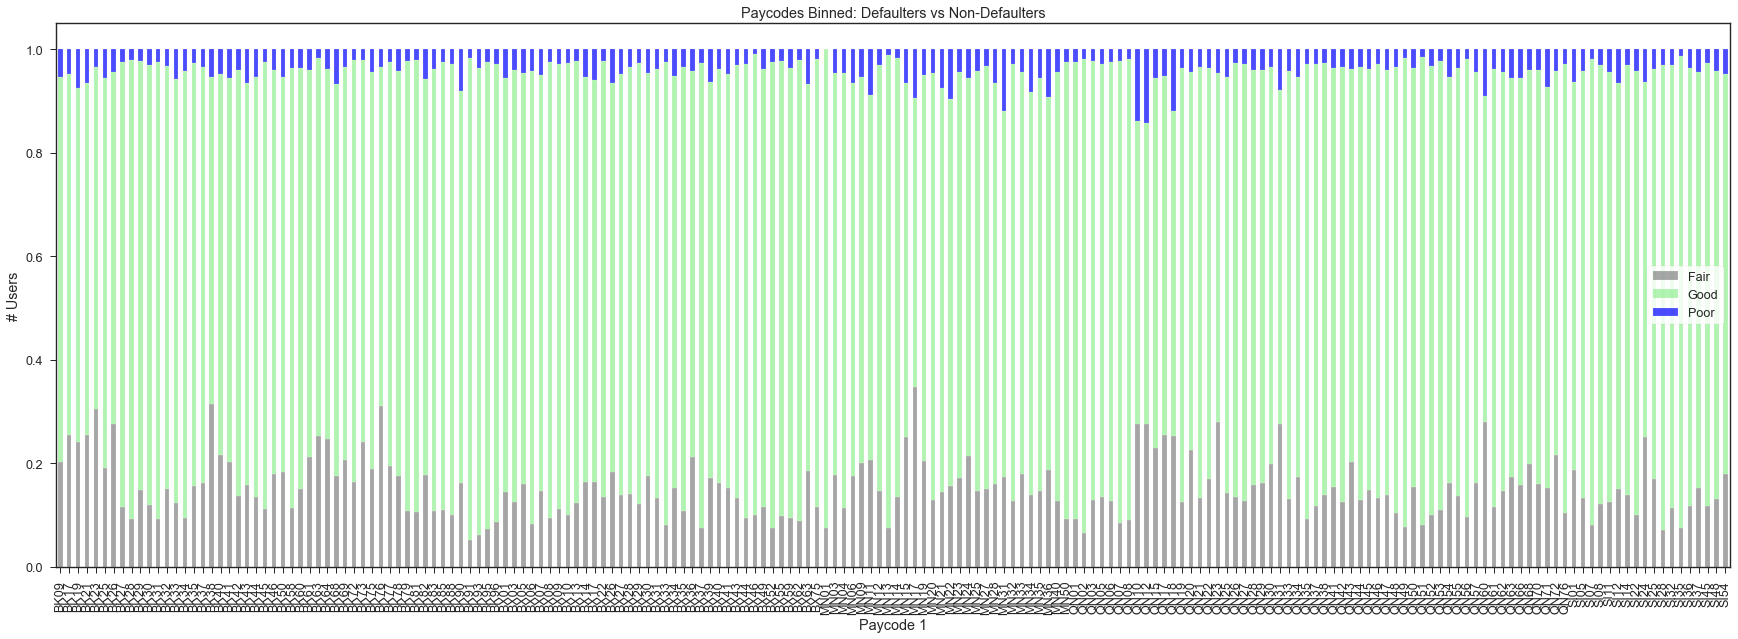

In [39]:
neighborhoods = trees.groupby(['nta']).health.value_counts(normalize=True).unstack()
p2 = neighborhoods.plot(kind = 'bar', stacked = True, figsize=(30,10),
                   title = 'Paycodes Binned: Defaulters vs Non-Defaulters', 
                   color = ['grey','lightgreen', 'blue'], alpha = .70)
p2.set_xlabel('Paycode 1')
p2.set_ylabel('# Users')
p2.legend(['Fair','Good', 'Poor'])
plt.show()

In [40]:
# create a dictionary of neighborhoods and their datapoints to perform two-way t-tests on
n_dict = {n: trees['health_num'][trees['nta'] == n] for n in list(trees.nta.unique())}
# run two-way t-tests function
n_t_test_dict = two_way_tests_dicts(n_dict)
# compare amount of statistically significant to statistically insignificant
significant_n = len({k:v for k,v in n_t_test_dict.items() if n_t_test_dict[k].pvalue < 0.05})
insignificant_n = len({k:v for k,v in n_t_test_dict.items() if n_t_test_dict[k].pvalue > 0.05})
print(f'Amount of statistically significant comparisons: {significant_n}')
print(f'Amount of statistically insignificant comparisons: {insignificant_n}')
print(f'Percentage of significant comparisons: {round((significant_n/(significant_n+insignificant_n))*100, 1)}%')

Amount of statistically significant comparisons: 13129
Amount of statistically insignificant comparisons: 4449
Percentage of significant comparisons: 74.7%


In [41]:
significant_n/(significant_n+insignificant_n)

0.7468995335077938

### EDA - Tree species

In [42]:
print(f'Number of unique species: {len(trees.spc_common.unique())}')
print(f'Number of total trees: {len(trees)}')
print(f'Cutoff for trees of significant quantity (0.1% of total trees): {np.ceil(len(trees)/1000)}')

Number of unique species: 132
Number of total trees: 444390
Cutoff for trees of significant quantity (0.1% of total trees): 445.0


In [43]:
# create a column with the total count of that row's tree species
species_counts = trees['spc_common'].value_counts().rename('species_counts')

# merge onto dataframe
trees = trees.merge(species_counts.to_frame(),
                                left_on='spc_common',
                                right_index=True)

# reassign tree species with fewer than 445 datapoints to 'Other'
trees['spc_common'] = np.where(trees.species_counts < 445, 'Other', trees.spc_common)

trees.spc_common.value_counts().head(20)

London planetree     60350
Callery pear         42487
honeylocust          38349
pin oak              35985
Norway maple         25253
cherry               22772
Japanese zelkova     18928
littleleaf linden    18469
red maple            13906
ginkgo               11355
green ash            10572
Sophora              10440
silver maple         10081
Other                 9918
American linden       8399
sweetgum              8380
purple-leaf plum      5281
maple                 5211
American elm          5192
northern red oak      5153
Name: spc_common, dtype: int64

In [44]:
# create a dictionary of neighborhoods and their datapoints to perform two-way t-tests on
species_dict = {spc: trees['health_num'][trees['spc_common'] == spc] for spc in list(trees.spc_common.unique())}
# run two-way t-tests function
spc_t_test_dict = two_way_tests_dicts(species_dict)
# compare amount of statistically significant to statistically insignificant
significant_spc = len({k:v for k,v in spc_t_test_dict.items() if spc_t_test_dict[k].pvalue < 0.05})
insignificant_spc = len({k:v for k,v in spc_t_test_dict.items() if spc_t_test_dict[k].pvalue > 0.05})
print(f'Amount of statistically significant comparisons: {significant_spc}')
print(f'Amount of statistically insignificant comparisons: {insignificant_spc}')
print(f'Percentage of significant comparisons: {round((significant_spc/(significant_spc+insignificant_spc))*100, 1)}%')

Amount of statistically significant comparisons: 1421
Amount of statistically insignificant comparisons: 724
Percentage of significant comparisons: 66.2%


In [45]:
trees.drop(columns='species_counts', axis=1, inplace=True)

In [46]:
trees.to_csv('data/nyc_trees_2015_pre_dummies.csv')

In [47]:
please break this code

SyntaxError: invalid syntax (<ipython-input-47-efdb6d3705b6>, line 1)

### Dummy columns

In [48]:
trees.columns

Index(['tree_dbh', 'curb_loc', 'health', 'spc_common', 'steward', 'guards',
       'sidewalk', 'root_stone', 'root_grate', 'root_other', 'trunk_wire',
       'trunk_light', 'trunk_other', 'branch_light', 'branch_shoe',
       'branch_other', 'cb_num', 'boroname', 'nta', 'health_num'],
      dtype='object')

In [49]:
trees.curb_loc.unique()

array(['OnCurb', 'OffsetFromCurb'], dtype=object)

In [50]:
trees.sidewalk.unique()

array(['NoDamage', 'Damage'], dtype=object)

In [51]:
trees.user_type.unique()

AttributeError: 'DataFrame' object has no attribute 'user_type'

In [ ]:
# rename columns that we have to manually dummy, so the new 0 and 1 values make sense
trees.rename(columns={'curb_loc': 'on_curb', 'sidewalk': 'sidewalk_damage', 'user_type': 'pro_entry'}, inplace=True)

# trees on curb = 1; trees offset from curb = 0
trees.on_curb = np.where(trees.on_curb == 'OnCurb', 1, 0)
# damage to sidewalk near tree = 1; no sidewalk damage = 0
trees.sidewalk_damage = np.where(trees.sidewalk_damage == 'Damage', 1, 0)
# Professional staff (TreesCount & NYC Parks) = 1; volunteers = 0
trees.pro_entry = np.where(trees.pro_entry == 'Volunteer', 0, 1)

In [ ]:
trees.branch_other.unique()

* Reassign yes-no columns to 1s and 0s.

In [ ]:
# create list of columns to dummy
yes_no_cols = ['root_stone', 'root_grate', 'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
               'branch_light', 'branch_shoe', 'branch_other']

# call custom function
yes_to_one(trees, yes_no_cols)
# check to make sure it worked
trees.branch_other.unique()

* First rename a steward value that doesn't make sense (4 is accounted for twice, so renaming '4orMore' to '5plus').
* Create dummies for number of stewards, usefulness of tree guards, and borough name.
* Hold off on creating dummies for community board numbers and neighborhood codes.

In [ ]:
trees['steward'] = np.where(trees.steward == '4orMore', '5plus', trees.steward)

In [ ]:
trees.steward.unique()

In [ ]:
trees.groupby('steward').health.value_counts(normalize=True)

In [ ]:
trees.guards.value_counts()

In [ ]:
trees.groupby('guards').health.value_counts(normalize=True)

In [ ]:
trees.boroname.unique()

In [ ]:
dummy_cols = ['steward', 'guards', 'boroname']

In [ ]:
tree_dummies = pd.get_dummies(trees[dummy_cols])
tree_dummies.columns

In [ ]:
dummy_cols.extend(['steward_None', 'guards_None', 'boroname_Staten Island'])
trees = pd.concat([trees,tree_dummies], axis=1)
trees.drop(columns=dummy_cols, axis=1, inplace=True)

In [ ]:
trees.columns

In [ ]:
trees.head()

## SAVE A COPY

In [ ]:
trees.to_csv('data/nyc_trees_2015.csv')

In [ ]:
trees = pd.read_csv('data/nyc_trees_2015.csv', index_col=0)
trees.head()

In [ ]:
trees.tree_dbh.describe()

In [ ]:
trees[trees.tree_dbh <= 37].hist('tree_dbh', bins=10)

In [ ]:
trees[trees.tree_dbh == 425]

In [ ]:
trees.nta.value_counts()

In [ ]:
with open('data/nta_dict.pickle', 'rb') as f:
    nta_dict = pickle.load(f)

In [ ]:
nta_dict['QN46']

In [ ]:
trees.columns

## Vanilla models

In [ ]:
df_van = trees.copy()

In [ ]:
X_van = df_van.drop(columns=['health', 'spc_common', 'nta'], axis=1)
y_van = df_van['health']

In [ ]:
X_train_van, X_test_van, y_train_van, y_test_van = train_test_split(X_van, y_van, random_state=42, stratify=y_van)

### Resample

In [ ]:
# concatenate our training data back together
training  = pd.concat([X_train_van, y_train_van], axis=1)

In [ ]:
# separate minority and majority classes
good = training[training.health=='Good']
fair = training[training.health=='Fair']
poor = training[training.health=='Poor']

In [ ]:
# Get a class count to understand the class imbalance.
print('good count: '+ str(len(good)))
print('fair count: '+ str(len(fair)))
print('poor count: '+ str(len(poor)))

In [ ]:
# downsample majority
good_downsampled = resample(good,
                                replace = False, # sample without replacement
                                n_samples = len(poor), # match minority n
                                random_state = 42) # reproducible results

# downsample majority
fair_downsampled = resample(fair,
                                replace = False, # sample without replacement
                                n_samples = len(poor), # match minority n
                                random_state = 42) # reproducible results

In [ ]:
# combine minority and downsampled majority
downsampled = pd.concat([good_downsampled, fair_downsampled, poor])

# checking counts
downsampled.health.value_counts()

In [ ]:
# trying logistic regression again with the balanced dataset
y_train_down = downsampled.health
X_train_down = downsampled.drop('health', axis=1)


# downsampled_dt = DecisionTreeClassifier(max_depth=5)
downsampled_lr = LogisticRegression(class_weight='balanced', multi_class='multinomial')


# downsampled_dt.fit(X_train, y_train)
downsampled_lr.fit(X_train_down, y_train_down)

# downsampled_pred = upsampled_dt.predict(X_test)
downsampled_pred = downsampled_lr.predict(X_test_van)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test_van, downsampled_pred))

# checking accuracy
print('Test F1 score: ', f1_score(y_test_van, downsampled_pred, average='weighted'))

In [ ]:
# params_knn = {
#     'n_neighbors': range(1,21,2),
#     'weights': ['uniform', 'distance'],
# #     'algorithm': ['ball_tree', 'kd_tree', 'brute'],
#     'p': range(1,4)
# }

In [ ]:
# CV_knn_van = GridSearchCV(KNeighborsClassifier(), params_knn, n_jobs=-1, scoring='accuracy', verbose=1)

# CV_knn_van.fit(X_train_van, y_train_van)

In [ ]:
# ### Identify the best params 
# print(CV_knn_van.best_estimator_)

# #Identify the best score during fitting with cross-validation
# print(CV_knn_van.best_score_)

In [ ]:
# #predict on the test set
# y_pred_knn_van = CV_knn_van.best_estimator_.predict(X_test_van)

# # checking metrics
# print('Test Accuracy score: ', accuracy_score(y_test_van, y_pred_knn_van))
# print('Test Precision score: ', precision_score(y_test_van, y_pred_knn_van))
# print('Test Recall score: ', recall_score(y_test_van, y_pred_knn_van))
# print('Test F1 score: ', f1_score(y_test_van, y_pred_knn_van))

In [ ]:
param_grid = { 
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [.0001, .001, .01, .1, 1.0, 10.0, 100.0],
    'solver': ['sag', 'saga', 'liblinear'],
}

In [ ]:
van_weight = LogisticRegression(class_weight='balanced', multi_class='multinomial')
van_weight.fit(X_train_van, y_train_van)

#predict on the test set
y_pred_van_weight = van_weight.predict(X_test_van)

In [ ]:
# checking metrics
print('Test Accuracy score: ', accuracy_score(y_test_van, y_pred_van_weight))
print('Test Precision score: ', precision_score(y_test_van, y_pred_van_weight, average='weighted'))
print('Test Recall score: ', recall_score(y_test_van, y_pred_van_weight, average='weighted'))
print('Test F1 score: ', f1_score(y_test_van, y_pred_van_weight, average='weighted'))

In [ ]:
#create a grid search object and fit it to the data
CV_van_weight = GridSearchCV(LogisticRegression(class_weight='balanced'),
                      param_grid, n_jobs=-1, scoring='accuracy', verbose=2)

CV_van_weight.fit(X_train_van, y_train_van)

In [ ]:
### Identify the best params 
print(CV_van_weight.best_estimator_)

#Identify the best score during fitting with cross-validation
print(CV_van_weight.best_score_)

In [ ]:
#predict on the test set
y_pred_van_weight = CV_van_weight.best_estimator_.predict(X_test_van)

# checking metrics
print('Test Accuracy score: ', accuracy_score(y_test_van, y_pred_van_weight))
print('Test Precision score: ', precision_score(y_test_van, y_pred_van_weight))
print('Test Recall score: ', recall_score(y_test_van, y_pred_van_weight))
print('Test F1 score: ', f1_score(y_test_van, y_pred_van_weight))

In [ ]:
trees[trees.nta == 'QN17'].iloc[:, 10:].head()

In [ ]:
print(len(trees.cb_num.unique()))
trees.cb_num.unique()

In [ ]:
print(len(trees.nta.unique()))
trees.nta.unique()

In [ ]:
trees.iloc[:, 10:].head(10)

In [ ]:
trees.spc_common.value_counts().head(10).keys()

In [ ]:
trees_most_pop = trees[trees.spc_common.isin(['London planetree', 'honeylocust', 'Callery pear', 'pin oak',
       'Norway maple', 'littleleaf linden', 'cherry', 'Japanese zelkova',
       'ginkgo', 'Sophora'])]
trees_most_pop.head()

In [ ]:
boros = trees.groupby(['boroname']).health.value_counts(normalize=True).unstack()

In [ ]:
# print('Paycode 1 Summary')

# print('\n')
# print(df_train.groupby(['pay_1_bin','default']).pay_1_bin.count().unstack())

# Passenger class visualization
species_health = trees_most_pop.groupby('spc_common').health.value_counts(normalize=True).unstack().head(10)
p1 = species_health.plot(kind = 'bar', stacked = True, 
                   title = 'Paycodes Binned: Defaulters vs Non-Defaulters', 
                   color = ['grey','lightgreen', 'blue'], alpha = .70)
p1.set_xlabel('Paycode 1')
p1.set_ylabel('# Users')
p1.legend(['Fair','Good', 'Poor'])
plt.show()

In [ ]:
trees[trees.spc_common == 'London planetree'].health.value_counts(normalize=True)

In [ ]:
trees.groupby('spc_common').health.value_counts(normalize=True)

In [ ]:
trees.columns

In [ ]:
trees.trunk_light.unique()

In [ ]:
trees.problems.value_counts()

In [ ]:
trees.shape

In [ ]:
trees.columns

In [ ]:
len(trees.council_dist.unique())

In [ ]:
len(trees.tree_dbh.unique())

In [ ]:
len(trees.block_id.unique())

In [ ]:
trees.health.value_counts()

In [ ]:
trees.health.value_counts(normalize=True)

In [ ]:
trees.health.isna().sum()

In [ ]:
trees.status.value_counts()

In [ ]:
trees[trees.health.isna()].head(20)

In [ ]:
trees.columns

In [ ]:
trees.curb_loc.unique()

In [ ]:
trees.borocode.value_counts()

In [ ]:
trees.drop(columns=['status'], axis=1)